# Example 1: 
* single cell segmentation and classification of cells for rare disease project:

In [ ]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

# %load_ext tensorboard
# %load_ext tensorboard.notebook
# %tensorboard --logdir {logs_base_dir}

import comet_ml
import sys
sys.path.insert(0, '/home/marziehhaghighi/workspace_DL/Mask_RCNN')
import os
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import copy
import cell
config = cell.cellConfig()
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [1]:
import skimage as sk
sk.__version__

'0.17.2'

In [ ]:
30616/60

In [1]:
# plt.figure()
# plt.imshow(np.ones((4,4)))
a = [[1, 2], [3, 4]]
# np.pad(a, ((0, 0), (0, 4)), 'constant', constant_values=(0))
np.pad(a, ((0, 0), (0, 4)), 'constant', constant_values=(0))

#### Project specific parameters

In [2]:
project_name="rare_disease_classification"

#### directories
dataset_dir='/storage/data/marziehhaghighi/rareDisease/'
# model_dir = "/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/"
# model_dir = "/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/"+project_name+"/"
MODEL_Root_DIR

#### all data information in one dataframe
# annotDate='20200208'
annotDate='20200208-scMarziehModif'
dfInfo = pd.read_csv(dataset_dir+'PILOT_1_maxproj/df-Info-'+annotDate+'-test.csv')


### read the raw file for the df Info to form test datset for unannotated images by Marzi
# dfInfo_raw = pd.read_csv(dataset_dir+'PILOT_1_maxproj/scLebelsImgs-'+annotDate+'.csv')
dfInfo.loc[(dfInfo['Metadata_Location2']=='na') | (dfInfo['Metadata_Location2']=='?'),'subset_label']="test"

In [39]:
# dfInfo.Metadata_Label.unique()

In [3]:
/storage/data/marziehhaghighi/rareDisease/deepLearningModels/

In [92]:
# dfInfo.columns
# dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]

#### Run/Experiment specific parameters

In [2]:
# train / test mode
trainMode=1;
testMode=0;

# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "coco"

# mask head network to use --> "def" , "unet"
maskBranchNet='def';

# layers to train --> "all" , "heads"
layers_to_tune="heads"

# number of randomly selected samples for validation
n_rand_val=3

In [27]:
# model_dir
# testImIds
# dfInfo[dfInfo['subset_label']=='test']
# dfInfo['Metadata_Label']

In [5]:
dfInfo.head()

Metadata_Plate Metadata_Well  Metadata_Site Metadata_Location2  \
0      RC4_IF_43           G04              2          cytoplasm   
1      RC4_IF_43           G04              2        perinuclear   
2      RC4_IF_43           G04              2      not expressed   
3      RC4_IF_43           G04              2      not expressed   
4      RC4_IF_43           G04              2      not expressed   

  Metadata_Location  ObjectNumber  ClustersForGFP  Nuclei_Location_Center_X  \
0  perinuclear foci            12               1                668.219256   
1  perinuclear foci            33               1                284.860093   
2     not expressed             2               0                317.139393   
3     not expressed             3               0                189.935506   
4     not expressed             4              -1                554.033642   

   Nuclei_Location_Center_Y  \
0                322.023299   
1                863.067541   
2                111.299443   
3                143.718273   
4                142.660727   

                                         URL_OrigDNA  ...            P-W-S  \
0  /storage/data/marziehhaghighi/rareDisease/PILO...  ...  RC4_IF_43-G04-2   
1  /storage/data/marziehhaghighi/rareDisease/PILO...  ...  RC4_IF_43-G04-2   
2  /storage/data/marziehhaghighi/rareDisease/PILO...  ...  RC4_IF_43-G04-2   
3  /storage/data/marziehhaghighi/rareDisease/PILO...  ...  RC4_IF_43-G04-2   
4  /storage/data/marziehhaghighi/rareDisease/PILO...  ...  RC4_IF_43-G04-2   

                   bbox image_id cat_id  \
0  [570, 232, 203, 206]       56      5   
1  [189, 730, 196, 207]       56     18   
2   [243, 35, 153, 164]       56     12   
3   [106, 52, 151, 196]       56     12   
4   [479, 47, 149, 225]       56     12   

                                            im_paths height width  iscrowd  \
0  ['/storage/data/marziehhaghighi/rareDisease/PI...   1080  1080        0   
1  ['/storage/data/marziehhaghighi/rareDisease/PI...   1080  1080        0   
2  ['/storage/data/marziehhaghighi/rareDisease/PI...   1080  1080        0   
3  ['/storage/data/marziehhaghighi/rareDisease/PI...   1080  1080        0   
4  ['/storage/data/marziehhaghighi/rareDisease/PI...   1080  1080        0   

                                                mask subset_label  
0  /storage/data/marziehhaghighi/rareDisease/PILO...          val  
1  /storage/data/marziehhaghighi/rareDisease/PILO...          val  
2  /storage/data/marziehhaghighi/rareDisease/PILO...          val  
3  /storage/data/marziehhaghighi/rareDisease/PILO...          val  
4  /storage/data/marziehhaghighi/rareDisease/PILO...          val  

[5 rows x 25 columns]

In [4]:
config.project_name=project_name
config.head=maskBranchNet;
# fileNumModel='Mask_RCNN_testSet_pretrained_'+init_with+'_maskNet_'+maskBranchNet+'_train_'+layers_to_tune;
# MODEL_DIR = os.path.join(model_dir+fileNumModel+"/")

fileNumModel='pretrained_'+init_with+'_train_'+layers_to_tune+'_lr_'+str(lr)+'_'+config.assign_label_mode[0:5];
MODEL_DIR = MODEL_Root_DIR + config.NAME+'/'+fileNumModel

# partition dataset to train and validation
# dfInfo=dfInfo[dfInfo['subset_label']!='test'].reset_index(drop=True)
testImIds=dfInfo[dfInfo['subset_label']=='test']['image_id'].unique().tolist()
valImIds=list(np.random.choice(dfInfo[dfInfo['subset_label']!='test']['image_id'].unique().tolist(),n_rand_val))
trainImIds=list(set(dfInfo['image_id'].unique().tolist())-set(valImIds)-set(testImIds))
dfInfo.loc[dfInfo['image_id'].isin(trainImIds),'subset_label']="train"
dfInfo.loc[dfInfo['image_id'].isin(valImIds),'subset_label']="val"

notexp_cat_id=dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]
dfInfo.loc[dfInfo['subset_label']=='test','Metadata_Label']='not expressed'
dfInfo.loc[dfInfo['subset_label']=='test','cat_id']=notexp_cat_id


# prepare train dataset
dataset_train = cell.cellsDataset()
dataset_train.load_cells(dataset_dir,dfInfo,"train")
dataset_train.prepare()


# prepare validation dataset
dataset_val = cell.cellsDataset()
dataset_val.load_cells(dataset_dir,dfInfo,"val")
dataset_val.prepare()


# prepare test dataset
dataset_test = cell.cellsDataset()
dataset_test.load_cells(dataset_dir,dfInfo,"test")
dataset_test.prepare()

if trainMode:
# if 1:
    
    # create model
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)   

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        
        COCO_MODEL_PATH = os.path.join(model_dir+'/pretrained_coco/', "mask_rcnn_coco.h5")
        if not os.path.exists(COCO_MODEL_PATH):
            utils.download_trained_weights(COCO_MODEL_PATH)
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)
        
        
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE / 10,
#                 learning_rate=config.LEARNING_RATE / 10,
                epochs=200, 
                layers=layers_to_tune);    

creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(4, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 128, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 128, 20), dtype=float32)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 128, 20), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 128, 20), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 128, 20), dtype=float32)
pred_class_ids (?, 128)
target_class_ids (4, ?)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 128, 20), dtype=float32)
pred_class_ids (?, 128)
target_class_ids (?, 128)

Starting at epoch 0. LR=0.0001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_heads/cell20200617T1550/mask_rcnn_cell_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_c

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 191s 2s/step - loss: 4.2788 - rpn_class_loss: 0.5894 - rpn_bbox_loss: 1.1629 - mrcnn_class_loss: 1.0975 - mrcnn_bbox_loss: 0.7783 - mrcnn_mask_loss: 0.6507 - lambda_nmi: 1.0000 - val_loss: 3.3036 - val_rpn_class_loss: 0.0706 - val_rpn_bbox_loss: 0.8204 - val_mrcnn_class_loss: 1.0718 - val_mrcnn_bbox_loss: 0.7414 - val_mrcnn_mask_loss: 0.5994 - val_lambda_nmi: 1.0000
Epoch 2/200
100/100 [==============================] - 61s 610ms/step - loss: 2.8394 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.7183 - mrcnn_class_loss: 0.8726 - mrcnn_bbox_loss: 0.5912 - mrcnn_mask_loss: 0.5925 - lambda_nmi: 1.0000 - val_loss: 3.1274 - val_rpn_class_loss: 0.0461 - val_rpn_bbox_loss: 0.7181 - val_mrcnn_class_loss: 1.0448 - val_mrcnn_bbox_loss: 0.7338 - val_mrcnn_mask_loss: 0.5847 - val_lambda_nmi: 1.0000
Epoch 3/200
100/100 [==============================] - 62s 616ms/step - loss: 2.5918 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.7214 - mrcnn_class_loss: 0.7220 -

100/100 [==============================] - 61s 605ms/step - loss: 1.7141 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.4384 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.3932 - lambda_nmi: 1.0000 - val_loss: 2.1986 - val_rpn_class_loss: 0.0195 - val_rpn_bbox_loss: 0.6326 - val_mrcnn_class_loss: 0.6764 - val_mrcnn_bbox_loss: 0.3995 - val_mrcnn_mask_loss: 0.4706 - val_lambda_nmi: 1.0000
Epoch 40/200
100/100 [==============================] - 60s 602ms/step - loss: 1.6302 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.4139 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.3823 - lambda_nmi: 1.0000 - val_loss: 2.1149 - val_rpn_class_loss: 0.0212 - val_rpn_bbox_loss: 0.6375 - val_mrcnn_class_loss: 0.6317 - val_mrcnn_bbox_loss: 0.3752 - val_mrcnn_mask_loss: 0.4492 - val_lambda_nmi: 1.0000
Epoch 41/200
100/100 [==============================] - 61s 613ms/step - loss: 1.6540 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.40

100/100 [==============================] - 64s 638ms/step - loss: 1.3970 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.3202 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.3488 - lambda_nmi: 1.0000 - val_loss: 1.9538 - val_rpn_class_loss: 0.0270 - val_rpn_bbox_loss: 0.6258 - val_mrcnn_class_loss: 0.5376 - val_mrcnn_bbox_loss: 0.3664 - val_mrcnn_mask_loss: 0.3969 - val_lambda_nmi: 1.0000
Epoch 78/200
100/100 [==============================] - 63s 633ms/step - loss: 1.3960 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.3502 - lambda_nmi: 1.0000 - val_loss: 1.9462 - val_rpn_class_loss: 0.0253 - val_rpn_bbox_loss: 0.6169 - val_mrcnn_class_loss: 0.5443 - val_mrcnn_bbox_loss: 0.3740 - val_mrcnn_mask_loss: 0.3857 - val_lambda_nmi: 1.0000
Epoch 79/200
100/100 [==============================] - 64s 637ms/step - loss: 1.4156 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.30

100/100 [==============================] - 63s 633ms/step - loss: 1.2658 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.3252 - lambda_nmi: 1.0000 - val_loss: 1.9268 - val_rpn_class_loss: 0.0268 - val_rpn_bbox_loss: 0.6008 - val_mrcnn_class_loss: 0.5587 - val_mrcnn_bbox_loss: 0.3837 - val_mrcnn_mask_loss: 0.3569 - val_lambda_nmi: 1.0000
Epoch 116/200
100/100 [==============================] - 66s 664ms/step - loss: 1.2889 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3263 - lambda_nmi: 1.0000 - val_loss: 1.9423 - val_rpn_class_loss: 0.0273 - val_rpn_bbox_loss: 0.5968 - val_mrcnn_class_loss: 0.5474 - val_mrcnn_bbox_loss: 0.3979 - val_mrcnn_mask_loss: 0.3729 - val_lambda_nmi: 1.0000
Epoch 117/200
100/100 [==============================] - 68s 683ms/step - loss: 1.2881 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.

100/100 [==============================] - 63s 629ms/step - loss: 1.1500 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4688 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.3109 - lambda_nmi: 1.0000 - val_loss: 2.0641 - val_rpn_class_loss: 0.0181 - val_rpn_bbox_loss: 0.6259 - val_mrcnn_class_loss: 0.6650 - val_mrcnn_bbox_loss: 0.3724 - val_mrcnn_mask_loss: 0.3827 - val_lambda_nmi: 1.0000
Epoch 154/200
100/100 [==============================] - 61s 613ms/step - loss: 1.1491 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4676 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.3119 - lambda_nmi: 1.0000 - val_loss: 2.0324 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 0.6271 - val_mrcnn_class_loss: 0.6355 - val_mrcnn_bbox_loss: 0.3779 - val_mrcnn_mask_loss: 0.3718 - val_lambda_nmi: 1.0000
Epoch 155/200
100/100 [==============================] - 62s 618ms/step - loss: 1.1346 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.4685 - mrcnn_class_loss: 0.

Process ForkPoolWorker-16:
Process ForkPoolWorker-50:
Process ForkPoolWorker-55:
Process ForkPoolWorker-64:
Process ForkPoolWorker-52:
Process ForkPoolWorker-38:
Process ForkPoolWorker-11:
Process ForkPoolWorker-58:
Process ForkPoolWorker-1:
Process ForkPoolWorker-34:
Process ForkPoolWorker-2:
Process ForkPoolWorker-44:
Process ForkPoolWorker-7:
Process ForkPoolWorker-43:
Process ForkPoolWorker-57:
Process ForkPoolWorker-37:
Process ForkPoolWorker-46:
Process ForkPoolWorker-21:
Process ForkPoolWorker-40:
Process ForkPoolWorker-24:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-35:
Traceback (most recent call last):
Process ForkPoolWorker-45:
Process ForkPoolWorker-49:
Process ForkPoolWorker-63:
Process ForkPoolWorker-61:
Process ForkPoolWorker-42:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Process ForkPoolWorker-51:
Process ForkPoolWorker-60:
Process ForkPoolWorker-53:
Process ForkPoolWorker-59:
Process ForkPoolWorker-12:
Process ForkPoolWorker-33

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self.

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/pool.p

  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 2134, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File

  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
Process ForkPoolWorker-4:
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 1634, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
KeyboardInterrupt
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 1642, in load_image_gt
    mask = utils.resize_mask(mask, scale, padding, crop)
KeyboardInterrupt
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/utils.py", line 71, in compute_iou
    y1 = np.maximum(box[0], boxes[:, 0])
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/skimage/transform/_warps.py", line 166, in resize
    preserve_range=preserve_range)
  File "skimage/transform/_warps_cy.pyx", line 183, in skimage.transform._warps_cy._warp_fast
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/utils.py", line 508, in resize_mask
    mask = scipy.ndimage.z

KeyboardInterrupt: 

In [6]:
# dataset_test = cell.cellsDataset()
# dataset_test.load_cells(dataset_dir,dfInfo,"test")
# dataset_test.prepare()

In [25]:
dataset_val.num_classes

20

In [13]:
print(config.RPN_ANCHOR_SCALES,
config.RPN_ANCHOR_RATIOS,
# config.backbone_shapes,
config.BACKBONE_STRIDES,
config.RPN_ANCHOR_STRIDE)

(8, 16, 32, 64, 128, 256) [0.5, 1, 2] [2, 4, 8, 16, 32, 64] 1


In [7]:
# import CellClass
# dfInfo = dfInfo[dfInfo['subset_label']=='test'];
# print(dfInfo.shape) 
# cell = CellClass.CELL(dfInfo)

In [83]:
# cell.dataset['annotations']
# cell.getImgIds(catIds=[11])

In [8]:
# dfInfo.loc[dfInfo['subset_label']=='test',:].head()

In [9]:
# dfInfo.columns

In [ ]:
rsync -rt /cmap/imaging/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1 haghighi@dgx01.broadinstitute.org:/dgx1nas1/cellpainting-datasets/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1

In [53]:
# dataset_val.class_from_source_map

In [54]:
# # dataset_train.class_from_source_map
# sorted(dataset_train.getCatIds())

In [55]:
# dataset_val.image_info[image_id]

In [58]:
# image_id=2
# dataset_val.source_class_ids[dataset_val.image_info[image_id]["source"]]

In [57]:
# dataset_val.image_info
# dataset_val.source_class_ids

In [56]:
# dataset_train.source_class_ids

In [59]:
# dataset_val.class_info

In [60]:
# dataset_train.class_info

In [6]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/


In [81]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/  cell20200512T0227/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/  cell20200512T0336/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/  cell20200513T0503/


In [9]:
# tensorboard --logdir /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/ --port=6009

In [10]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

In [61]:
model.find_last()

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def/cell20200520T2314/mask_rcnn_cell_0050.h5'

In [23]:
# [x[0] for x in os.walk(MODEL_DIR)][1]

In [62]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

#### Inference

In [5]:
class InferenceConfig(cell.cellConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head=maskBranchNet;
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
selectedEpoch='0337'
# model_path_2=[x[0] for x in os.walk(address)][1]+'/mask_rcnn_cell_'+selectedEpoch+'.h5';
model_path_2='/'.join(model_path.split('/')[:-1])+'/mask_rcnn_cell_'+str(selectedEpoch)+'.h5';

# model_path_2=model_path
# Load trained weights
print("Loading weights from ", model_path_2)
model.load_weights(model_path_2, by_name=True)

shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 1000, 20), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_heads/cell20200616T2229/mask_rcnn_cell_0337.h5


OSError: Unable to open file (unable to open file: name = '/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_heads/cell20200616T2229/mask_rcnn_cell_0337.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
config.LEARNING_RATE

0.001

In [8]:
model_path

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_all/cell20200522T0027/mask_rcnn_cell_0053.h5'

In [34]:
# dataset_val.class_names

In [15]:
# dataset_train.class_names
visualize.CP_to_RGB_single(image).dtype

dtype('float64')

In [16]:
image.dtype

dtype('uint8')

In [80]:
# plt.figure()
# plt.imshow(image[:,:,2])
dataset.image_ids

array([0, 1, 2])

In [6]:
%matplotlib inline
plt.figure()
plt.imshow(visualize.CP_to_RGB_single(image))

NameError: name 'image' is not defined

In [ ]:
print(1)

In [27]:
visualize.CP_to_RGB_single(image).dtype

255.0 0.0 (1080, 1080, 3)
255.0 0.0 (1080, 1080, 3)
255.0 0.0 (1080, 1080, 3)


dtype('uint8')

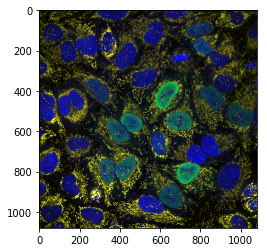

In [17]:
# visualize.display_images(visualize.CP_to_RGB_single(image),cols=0)
plt.figure()
plt.imshow(visualize.CP_to_RGB_single(image).astype(np.uint8))

<IPython.core.display.Javascript object>


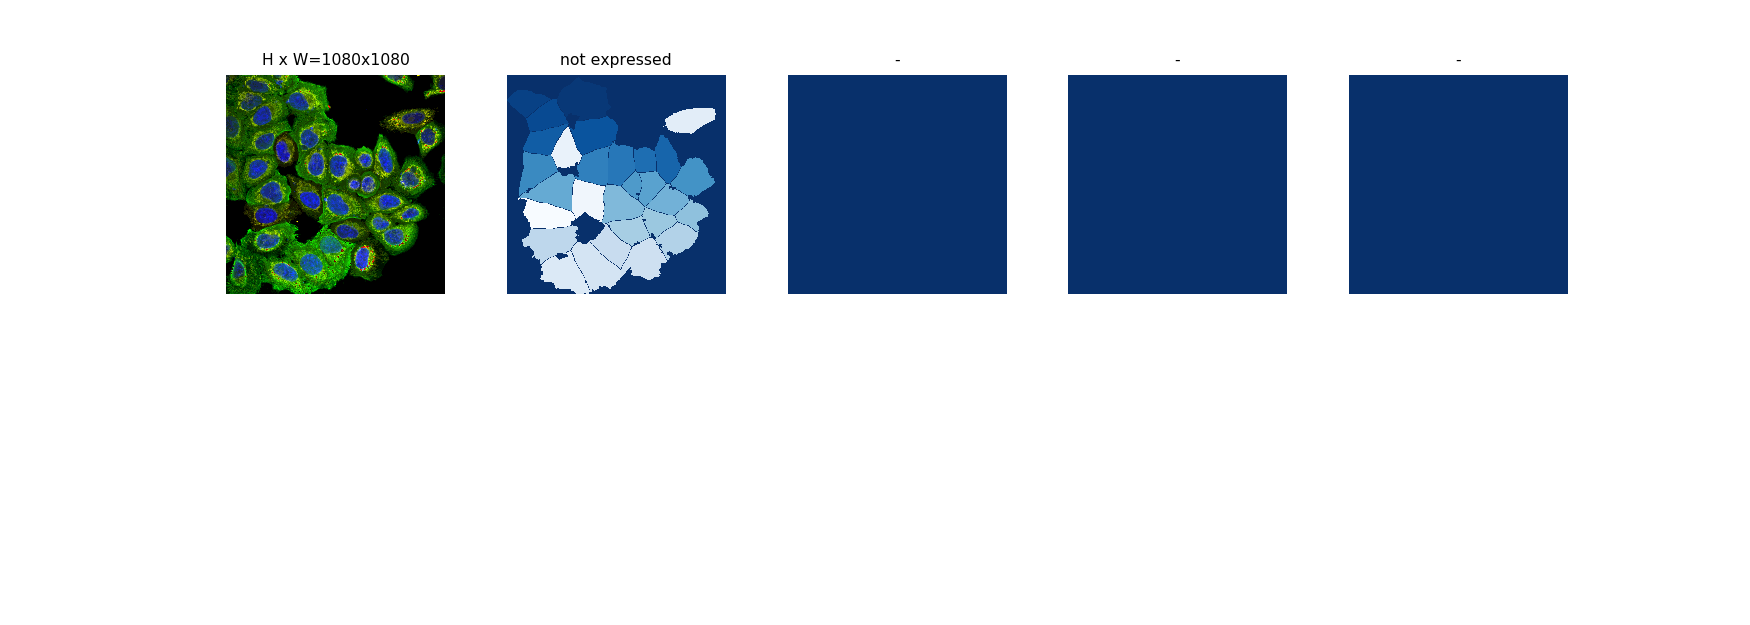

<IPython.core.display.Javascript object>


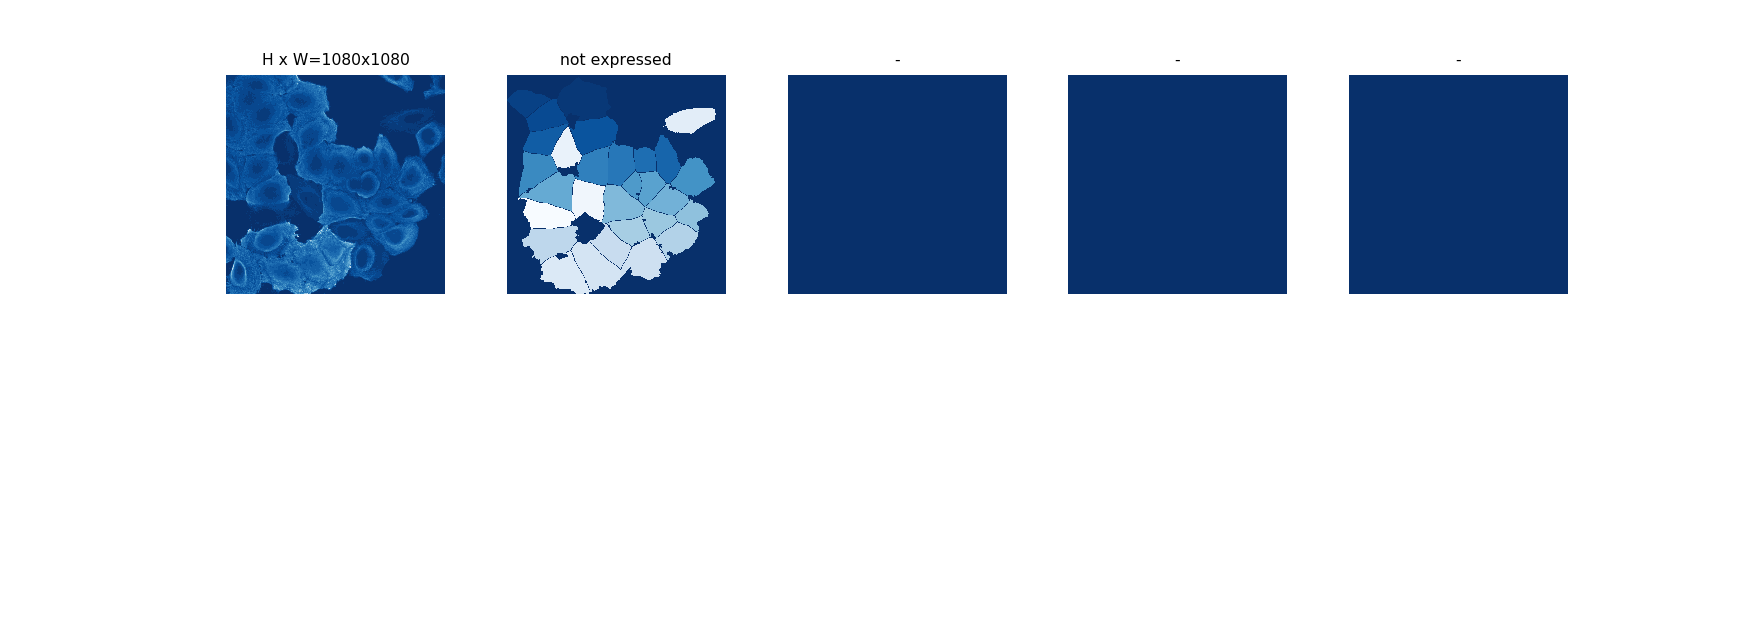

In [20]:

dataset=copy.copy(dataset_test)
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
#     print(mask[5,5])
visualize.display_top_masks(visualize.CP_to_RGB_single(image), mask, class_ids, dataset.class_names)
visualize.display_top_masks(image[:,:,1], mask, class_ids, dataset.class_names)

In [10]:
gt_class_id

array([ 9,  9, 17, 17, 17,  9,  9, 17, 17,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9], dtype=int32)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:   45.00000  uint8
image_meta               shape: (31,)                 min:    0.00000  max: 1080.00000  float64
gt_class_id              shape: (29,)                 min:    9.00000  max:    9.00000  int32
gt_bbox                  shape: (29, 4)               min:    1.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 29)      min:    0.00000  max:    1.00000  bool


<IPython.core.display.Javascript object>


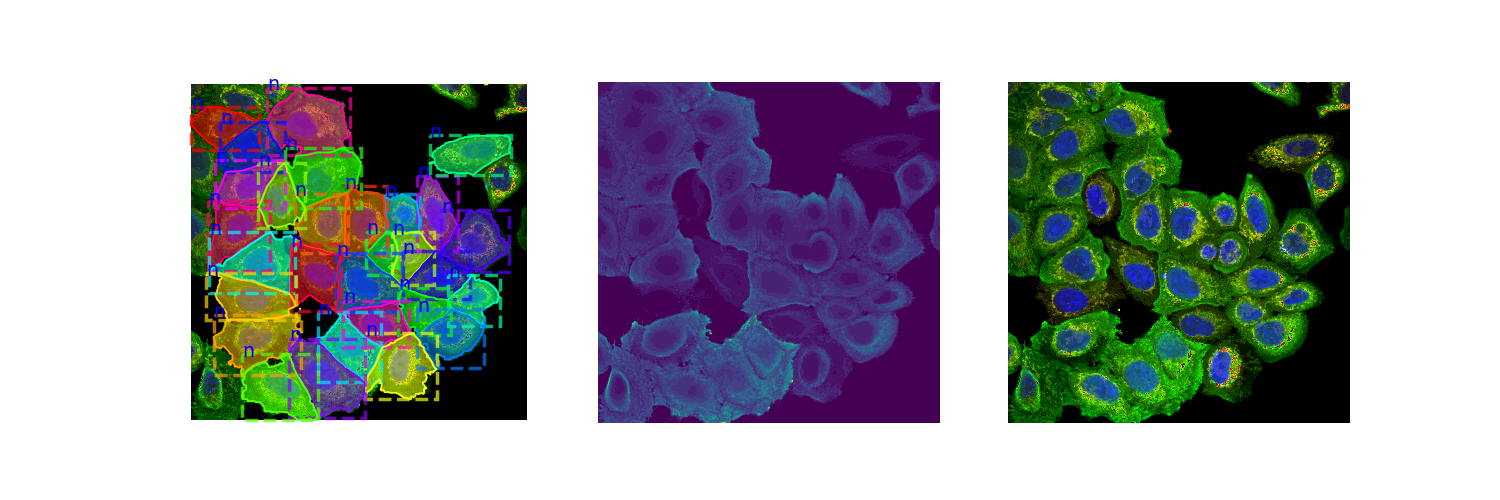

In [21]:
# %matplotlib inline
# Test on a random image from validation set
# dataset=copy.copy(dataset_val)

# image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(4*3, 4),to_RGB=True)

In [11]:
# results
original_image.max()

149

In [9]:
original_image.dtype

dtype('uint8')

In [50]:
# results = model.detect([original_image], verbose=1)
# results

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:   45.00000  uint8
image_meta (32,) [   0 1024 1024    3 1024 1024    3    0    0 1024 1024    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(1, 32)
[[[-0.00552967 -0.00276484  0.00455215  0.00178732]
  [-0.00391007 -0.00391007  0.00293255  0.00293255]
  [-0.00276484 -0.00552967  0.00178732  0.00455215]
  ...
  [ 0.8499417   0.89417905  1.0259136   0.9816763 ]
  [ 0.8758553   0.8758553   1.          1.        ]
  [ 0.89417905  0.8499417   0.9816763   1.0259136 ]]]
molded_images            shape: (1, 1024, 1024, 3)    min: -128.00000  max:  -83.00000  float64
image_metas              shape: (1, 32)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


<IPython.core.display.Javascript object>


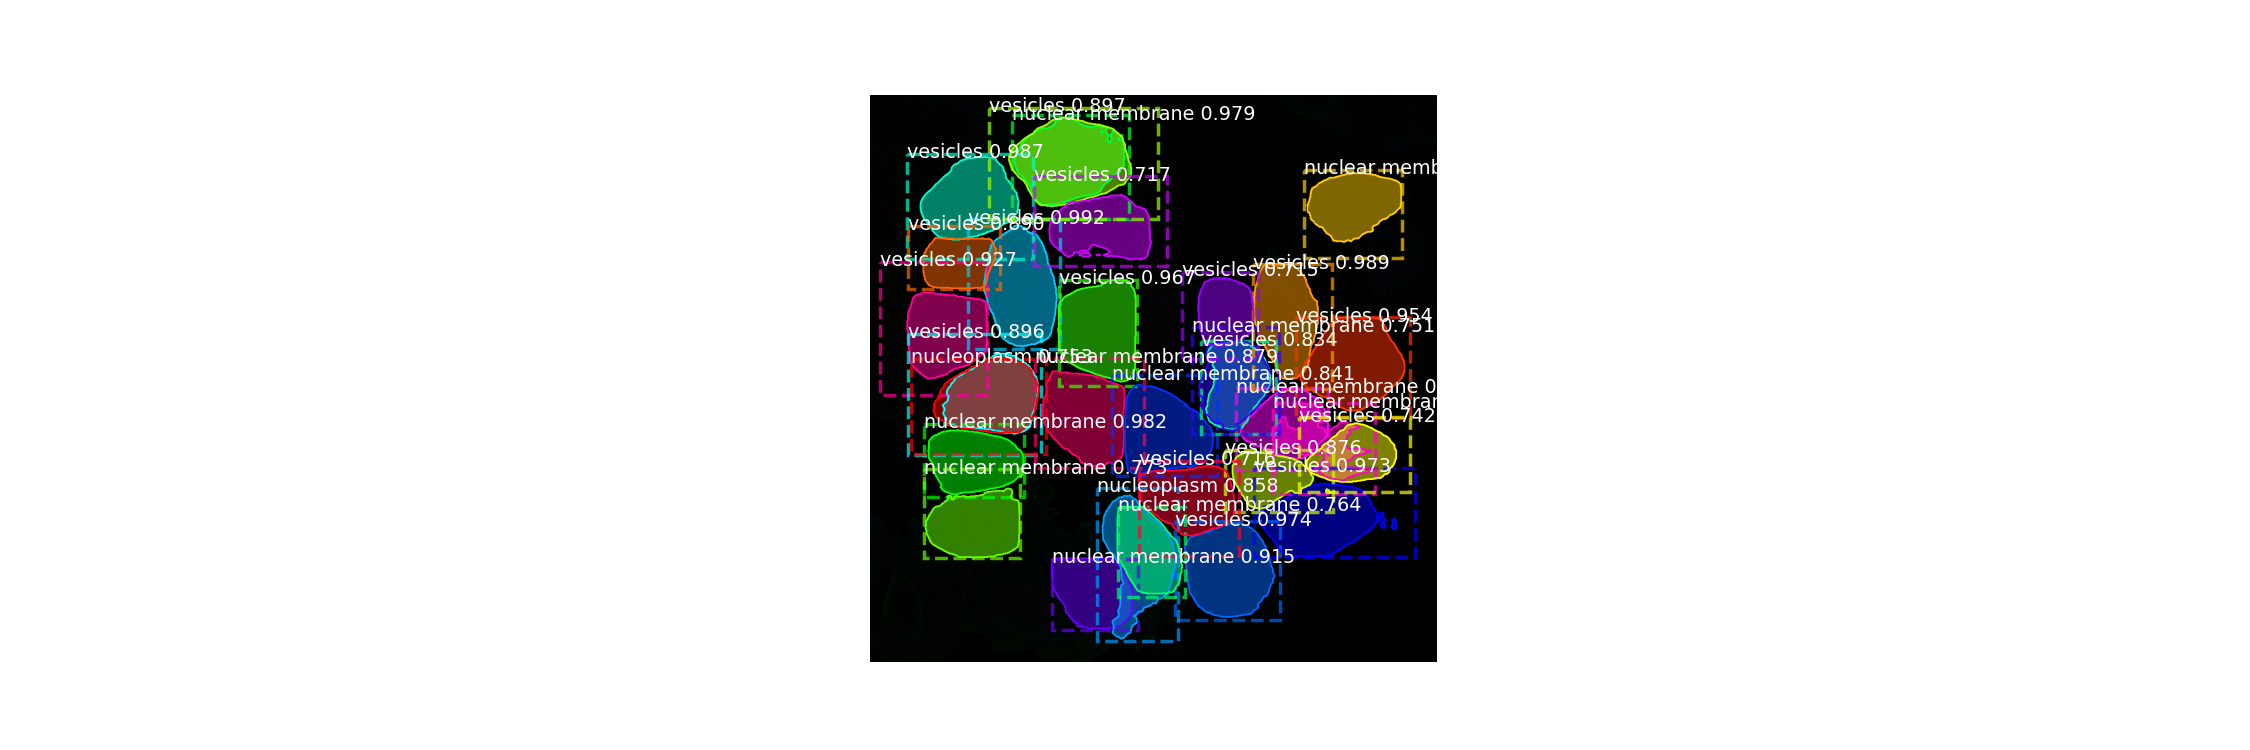

In [24]:
# %matplotlib notebook
results = model.detect([original_image], verbose=1)
# results
r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_train.class_names, r['scores'],figsize=(4*3, 4),to_RGB=True)
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'],figsize=(6*3, 6))

In [14]:
# fig,axes=plt.subplots(1,3,figsize=(10,30));
# axes[0].imshow(original_image[:,:,0]);axes[0].set_title('DNA');
# axes[1].imshow(original_image[:,:,1]);axes[1].set_title('Protein');
# # axes[2].imshow(CP_to_RGB_single(original_image));axes[2].set_title('color');
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [2, 4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                32
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE     

In [15]:
original_image.shape

(1024, 1024, 3)

In [16]:
orig_im=skimage.io.imread(imPath)
orig_im2=original_image[:,:,1]

In [17]:
orig_im.shape,orig_im2.shape

((1080, 1080), (1024, 1024))

In [20]:
orig_im.max(),orig_im2.max()

(65535, 255)

In [21]:
orig_im.min(),orig_im2.min()

(182, 0)

In [24]:
orig_im.dtype,orig_im2.dtype

(dtype('uint16'), dtype('uint8'))

In [18]:
orig_im.shape

(1080, 1080)

In [19]:
from scipy import stats
stats.describe(orig_im)

DescribeResult(nobs=1080, minmax=(array([240, 235, 219, ..., 278, 274, 279], dtype=uint16), array([ 3899,  3847,  3732, ..., 48464, 48531, 49751], dtype=uint16)), mean=array([ 491.14722222,  492.95648148,  494.69907407, ..., 5458.48796296,
       5412.7462963 , 5381.75      ]), variance=array([2.59597527e+05, 2.61089172e+05, 2.56731506e+05, ...,
       1.16336875e+08, 1.16221898e+08, 1.16668706e+08]), skewness=array([4.41157648, 4.32222954, 4.27648169, ..., 2.09518809, 2.14170093,
       2.18936505]), kurtosis=array([21.01086081, 19.90798038, 19.35927525, ...,  3.03768322,
        3.30472349,  3.56738775]))

In [69]:
dfInfo[['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

image_id                  bbox  cat_id            P-W-S  ObjectNumber  \
0        56  [570, 232, 203, 206]       5  RC4_IF_43-G04-2            12   
1        56  [189, 730, 196, 207]      18  RC4_IF_43-G04-2            33   
2        56   [243, 35, 153, 164]      12  RC4_IF_43-G04-2             2   
3        56   [106, 52, 151, 196]      12  RC4_IF_43-G04-2             3   
4        56   [479, 47, 149, 225]      12  RC4_IF_43-G04-2             4   

                                                mask  
0  /storage/data/marziehhaghighi/rareDisease/PILO...  
1  /storage/data/marziehhaghighi/rareDisease/PILO...  
2  /storage/data/marziehhaghighi/rareDisease/PILO...  
3  /storage/data/marziehhaghighi/rareDisease/PILO...  
4  /storage/data/marziehhaghighi/rareDisease/PILO...

In [67]:
dfInfo.loc[dfInfo['subset_label']=='test',:][['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

image_id                  bbox  cat_id            P-W-S  ObjectNumber  \
31         8   [905, 53, 134, 186]      11  RC4_IF_05-G04-3             4   
32         8   [147, 55, 106, 155]      11  RC4_IF_05-G04-3             5   
33         8   [628, 73, 120, 153]      11  RC4_IF_05-G04-3             6   
34         8  [767, 104, 170, 129]      11  RC4_IF_05-G04-3             7   
35         8   [470, 84, 160, 146]      11  RC4_IF_05-G04-3             8   

                                                 mask  
31  /storage/data/marziehhaghighi/rareDisease/PILO...  
32  /storage/data/marziehhaghighi/rareDisease/PILO...  
33  /storage/data/marziehhaghighi/rareDisease/PILO...  
34  /storage/data/marziehhaghighi/rareDisease/PILO...  
35  /storage/data/marziehhaghighi/rareDisease/PILO...

In [64]:
dataset.image_info[0]

{'id': 8,
 'source': 'cell',
 'path': "['/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch1sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch3sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch2sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch4sk1fk1fl1.tiff']",
 'width': 1080,
 'height': 1080,
 'annotations': []}

<IPython.core.display.Javascript object>


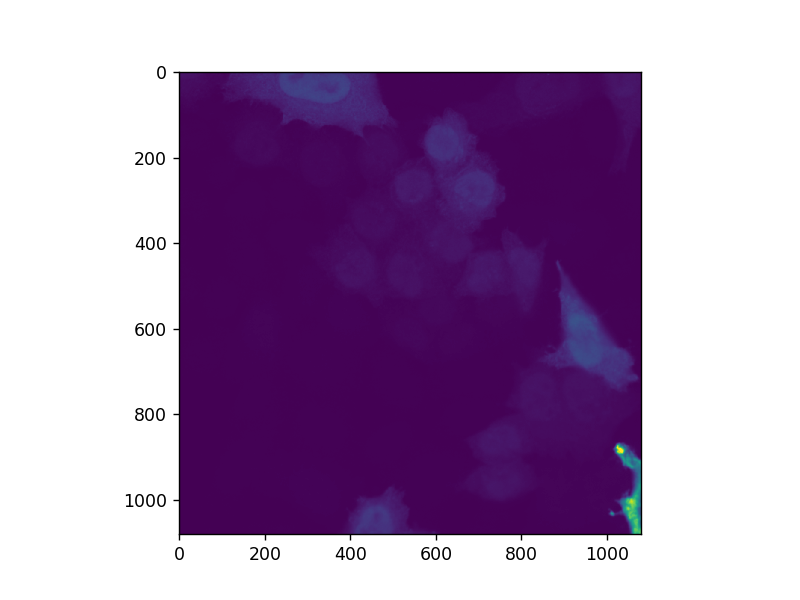

In [35]:
plt.figure()
plt.imshow(dataset.load_image(image_id)[:,:,1]);axes[0].set_title('Protein');

In [85]:
# dataset_test.load_image(image_id)

<IPython.core.display.Javascript object>


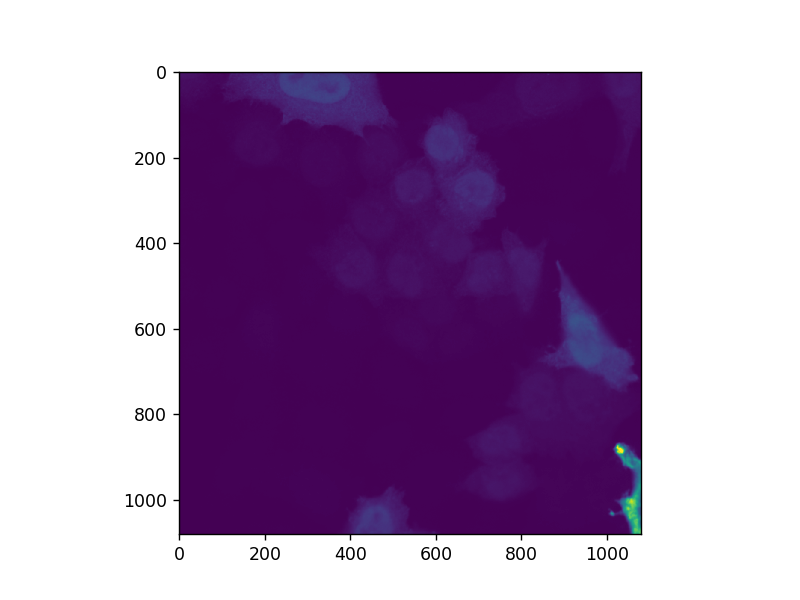

In [32]:
# dataset_test.load_image(image_id)
import skimage.io
from ast import literal_eval
imPath=literal_eval(dataset.image_info[image_id]['path'])[2]

plt.figure()
plt.imshow(skimage.io.imread(imPath))
#         print(len(listOfPaths))
#         listOfPaths=[listOfPaths[0],listOfPaths[2]]
#         listOfPaths=[listOfPaths[2]]
#         imagesList=[]
#         for imPath in listOfPaths:
# #             print(imPath)
#             imagesList.append(skimage.io.imread(imPath).astype('uint8'))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta (32,) [   0 1024 1024    3 1024 1024    3    0    0 1024 1024    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(1, 32)
molded_images            shape: (1, 1024, 1024, 3)    min: -128.00000  max:  126.00000  float64
image_metas              shape: (1, 32)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


<IPython.core.display.Javascript object>


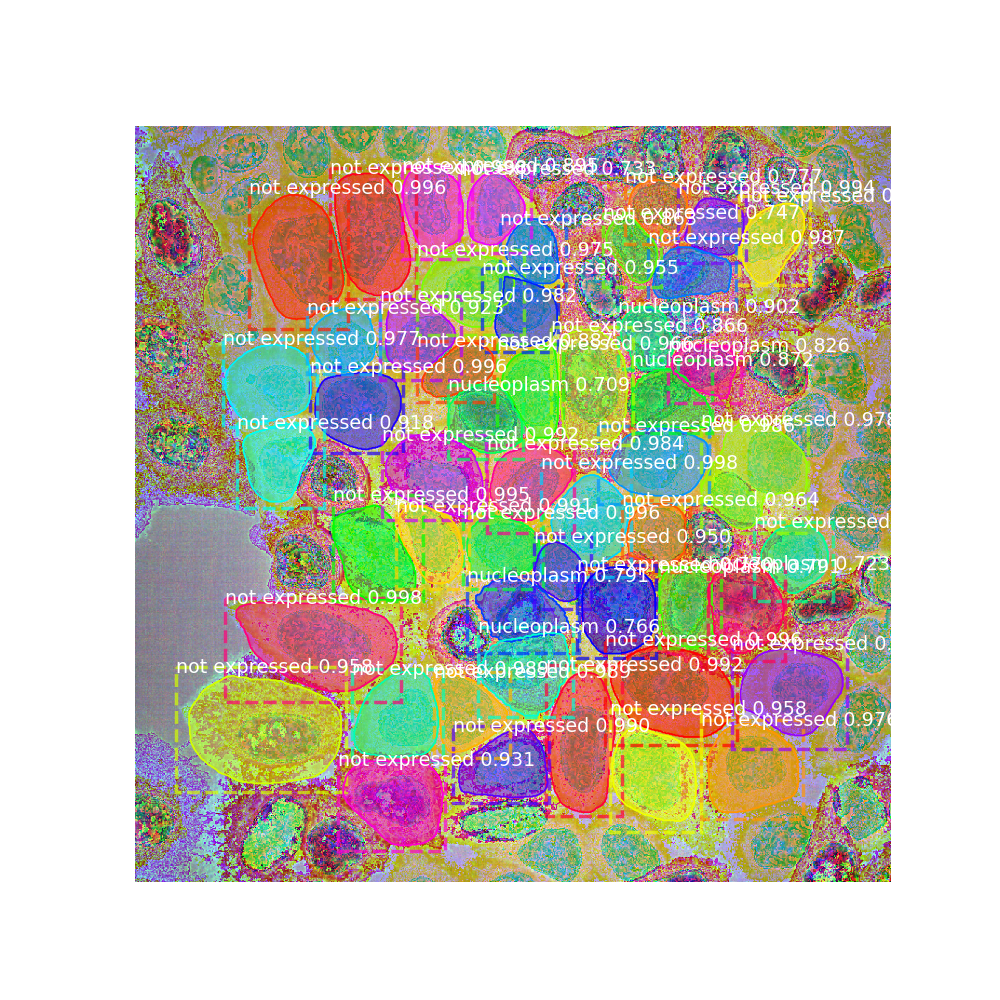

In [51]:
results = model.detect([original_image], verbose=1)
# results
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],figsize=(8, 8))

In [16]:
original_image

array([[[123, 145, 192],
        [113, 138, 164],
        [118, 134, 170],
        ...,
        [  2, 152,  80],
        [ 13, 192, 172],
        [ 31, 223, 208]],

       [[129, 126, 179],
        [113, 123, 189],
        [114, 124, 205],
        ...,
        [ 25, 180, 112],
        [ 19, 196, 182],
        [ 14, 249,  49]],

       [[126, 120, 185],
        [118, 131, 204],
        [116, 147, 180],
        ...,
        [ 71, 168, 136],
        [ 77, 152,  41],
        [ 44, 210,  78]],

       ...,

       [[108, 124, 195],
        [124, 120, 195],
        [115, 126, 180],
        ...,
        [150, 114,  57],
        [137, 163, 113],
        [142, 228, 202]],

       [[104, 125, 182],
        [121, 121, 183],
        [124, 129, 173],
        ...,
        [140, 147,  66],
        [145, 162, 122],
        [126, 172, 179]],

       [[117, 127, 201],
        [132, 127, 165],
        [130, 130, 192],
        ...,
        [122,  61,  47],
        [143,  45,  78],
        [135, 114, 129]]

In [33]:
original_image.shape

(128, 128, 1)

# Example 2:
    * single cell detection/segmentation and clustering

In [14]:

original_image[:,:,0].shape

(128, 128)

In [72]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [5]:
a

array([[0.61663802, 0.61383717, 0.87066265, 0.96142386, 0.33702554,
        0.02570697, 0.51764306, 0.67732591, 0.34833994, 0.08976734],
       [0.97313637, 0.82789055, 0.29779494, 0.25196196, 0.79023423,
        0.98380147, 0.65862496, 0.5168325 , 0.12261395, 0.1228047 ],
       [0.92379016, 0.51688631, 0.7518936 , 0.51252832, 0.52000422,
        0.0211729 , 0.58997096, 0.74332169, 0.73286817, 0.86289996],
       [0.73224991, 0.92540816, 0.85502321, 0.74281178, 0.66211381,
        0.65277928, 0.42671495, 0.7061217 , 0.18269861, 0.82430231],
       [0.27834282, 0.1199197 , 0.51363298, 0.1207112 , 0.78528219,
        0.21111073, 0.06885176, 0.34589997, 0.28795184, 0.96193354]])

In [20]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
distMat=dist.pairwise(a,b)

In [42]:
a[1,:]=np.nan
distMat=dist.pairwise(a,b)

In [45]:
distMat=distMat/np.nansum(distMat,axis=0)

In [46]:
distMat

array([[0.26154628, 0.21074095, 0.22038478, 0.20561807, 0.27869796],
       [       nan,        nan,        nan,        nan,        nan],
       [0.22709331, 0.22153612, 0.24308125, 0.28042593, 0.23947618],
       [0.18155977, 0.26286605, 0.24848488, 0.26448651, 0.27743563],
       [0.32980064, 0.30485688, 0.28804909, 0.24946949, 0.20439023]])

In [48]:
np.nansum(distMat,axis=0)

array([1., 1., 1., 1., 1.])

In [26]:
distMat.sum(axis=0)

array([1., 1., 1., 1., 1.])

In [ ]:
distMat=dist.pairwise(a,b)

In [19]:
a.sum(axis=1)

array([5.05837045, 5.54569564, 6.1753363 , 6.7102237 , 3.69363673])

In [68]:
map_dict={}
min_dist_clusters=np.argmin(distMat,axis=1)
non_nan_indexes=np.delete(range(5), 1)
# non_nan_indexes
for ci in non_nan_indexes:
    map_dict[ci]=min_dist_clusters[ci]

In [69]:
map_dict

{0: 3, 2: 1, 3: 0, 4: 4}

In [52]:
np.argmin(distMat,axis=1)

array([3, 0, 1, 0, 4])

In [65]:
(x==np.nan)

array([False, False, False, False, False])

In [61]:
x=distMat.sum(axis=1)

In [85]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [106]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

# nan_index_a=1
nan_index_b=2

# a[nan_index_a,:]=np.nan
b[nan_index_b,:]=np.nan

distMat=dist.pairwise(a,b)
distMat=distMat/np.nansum(distMat,axis=0)
map_dict={}
ordered_ass=np.argsort(distMat,axis=1)
min_dist_clusters=np.nanargmin(distMat,axis=1)
min_dist=np.nanmin(distMat,axis=1)
confid_ordered_labels = np.argsort(min_dist)
# non_nan_indexes=np.delete(range(5), 1)
non_nan_indexes=list(range(5))
for ci in range(5):
#     min_dist_clusters[ci]
    ind_cluster_to_ass=confid_ordered_labels[ci]
    if min_dist_clusters[ind_cluster_to_ass] in non_nan_indexes:
        map_dict[ind_cluster_to_ass]=min_dist_clusters[ind_cluster_to_ass]
        non_nan_indexes.remove(min_dist_clusters[ind_cluster_to_ass])
    else:
        i=1
        while ordered_ass[ind_cluster_to_ass,i] not in non_nan_indexes:
            i += 1
#         for i in range(1,5):
        to_cl=ordered_ass[ind_cluster_to_ass,i]
        map_dict[ind_cluster_to_ass]=to_cl
        non_nan_indexes.remove(to_cl)
    
map_dict
# min_dist_clusters

{4: 3, 3: 1, 2: 4, 0: 0, 1: 2}

In [104]:
min_dist_clusters

array([0, 1, 3, 1, 3])

In [105]:
min_dist

array([0.15761832, 0.21985004, 0.15649114, 0.13887848, 0.12695672])

In [99]:
np.argsort(min_dist)

array([4, 3, 2, 0, 1])

In [95]:
np.sort(distMat,axis=1)

array([[0.15761832, 0.23592548, 0.2729561 , 0.30295652,        nan],
       [0.21985004, 0.22560486, 0.2421656 , 0.26896968,        nan],
       [0.15649114, 0.19101082, 0.19149405, 0.19292334,        nan],
       [0.13887848, 0.16668402, 0.17462637, 0.2368094 ,        nan],
       [0.12695672, 0.14730414, 0.16373085, 0.18704409,        nan]])

In [100]:
ordered_ass=np.argsort(distMat,axis=1)
ordered_ass

array([[0, 4, 3, 1, 2],
       [1, 0, 4, 3, 2],
       [3, 1, 4, 0, 2],
       [1, 4, 3, 0, 2],
       [3, 1, 4, 0, 2]])

In [102]:
ordered_ass[:,1]

array([4, 0, 1, 4, 1])

In [107]:
np.nans((2,3))

AttributeError: module 'numpy' has no attribute 'nans'